In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
# Function to handle NaN values and get the NaN mask

def fill_nan(image):

    nan_mask = np.isnan(image)

    mean_value = np.nanmean(image)

    image[nan_mask] = mean_value

    return image, nan_mask



# Function to reconstruct the image using significant indices and their values

def reconstruct_compressed_image(image_shape, significant_indices, pixel_values):

    # Create an empty image with the given shape
    compressed_image = np.full(image_shape, np.nan)


    # Assign the provided pixel values to the significant indices
    compressed_image[significant_indices] = pixel_values


    # Interpolate to fill in the missing values
    x, y = np.meshgrid(np.arange(image_shape[1]), np.arange(image_shape[0]))

    mask = ~np.isnan(compressed_image)

    interpolated_image = griddata(

        (x[mask], y[mask]),  # Points with known values

        compressed_image[mask],  # Known values

        (x, y),  # Points to interpolate

        method='linear'  # Interpolation method

    )
    # nan_holes = np.isnan(interpolated_image)
    # if np.any(nan_holes):
    #     interpolated_nearest = griddata(
    #         (x[mask], y[mask]),
    #         compressed_image[mask],
    #         (x, y),
    #         method='nearest'
    #     )
    #     interpolated_image[nan_holes] = interpolated_nearest[nan_holes]

    return interpolated_image



# Function to perform SVD and reconstruct image using significant pixels

def compress_and_reconstruct(image, num_singular_values):

    # Handle NaN values and get the NaN mask

    image, nan_mask = fill_nan(image)


    # Perform SVD
    U, S, Vt = np.linalg.svd(image, full_matrices=False)


    # Keep only the top 'num_singular_values' singular values

    U_reduced = U[:, :num_singular_values]

    S_reduced = np.diag(S[:num_singular_values])

    Vt_reduced = Vt[:num_singular_values, :]

    # Reconstruct the image using significant pixels
    compressed_image = np.dot(U_reduced, np.dot(S_reduced, Vt_reduced))


    # Identify significant pixel indices based on contributions
    contributions = np.abs(U_reduced) @ np.abs(Vt_reduced)

    rows,cols = np.arange(image.shape[0]),np.arange(image.shape[1])
 
    z=rows/np.max(rows)
    z_factor=0.15
    depth_weight=1+z_factor*z   
    depth_weight=depth_weight[:,None] #2D IMPORTANT!!! 1D->WEIGHTING MORE TO DISTANT PIXELS  
    contributions*=depth_weight


    contributions[nan_mask] = -np.inf
    rows_0=np.where(~nan_mask[:,0])[0] #only non-nans for the fist column to force the linear interp   
    if len(rows_0)>0:
        r_min=rows_0[0]
        r_max=rows_0[-1]
        r_med=rows_0[len(rows_0)//2]
        contributions[r_min,0]=np.inf 
        contributions[r_max,0]=np.inf
        contributions[r_med,0]=np.inf   #force to include them

    flat_indices = np.argsort(contributions.flatten())[::-1][:num_singular_values]

    #flat_indices=np.r_[0,image.shape[0]*image.shape[1]-1,flat_indices]
    # Convert flat indices to 2D indices
    significant_indices = np.unravel_index(flat_indices, image.shape)

    # Restore NaN values in the original positions
    compressed_image[nan_mask] = np.nan
 
    return compressed_image, significant_indices,nan_mask


# Function to plot ERT measurements as a checkerboard heatmap
def plot_ert_checkerboard(data,plot=0):

    """
    Plots ERT measurements as a checkerboard heatmap.
    Parameters:
    data (pd.DataFrame): A DataFrame containing columns 'A', 'B', 'M', 'N', and 'Res'.
    """

    # Extract unique electrode positions

    electrodes = np.unique(data[['A', 'B', 'M', 'N']].values)

    electrode_map = {electrode: idx for idx, electrode in enumerate(sorted(electrodes))}

    # Create a grid
    grid_size = len(electrode_map)

    heatmap = np.full((grid_size, grid_size), np.nan)

    # Map values to the grid
    for _, row in data.iterrows():

        x = electrode_map[row['A']]

        y = electrode_map[row['M']]

        heatmap[y, x] = row['Res']


    if plot==1:

        # Plot the checkerboard heatmap

        plt.figure(figsize=(10, 8))

        plt.imshow(np.log10(heatmap), cmap='gist_rainbow', interpolation='nearest')

        plt.colorbar(label='ERT Measurement Value')

        plt.xticks(ticks=np.arange(grid_size), labels=sorted(electrode_map.keys()), rotation=90)

        plt.yticks(ticks=np.arange(grid_size), labels=sorted(electrode_map.keys()))

        plt.xlabel('Electrode A')

        plt.ylabel('Electrode N')

        plt.title('ERT Checkerboard Heatmap')

        plt.show()
    return heatmap

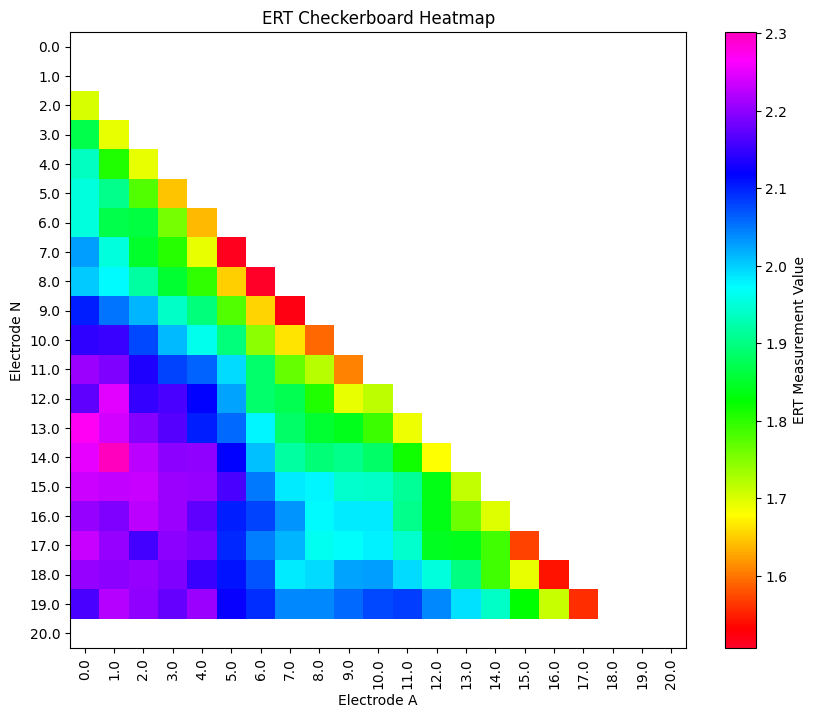

In [3]:
abmn=np.load('abmn_dd.npy')
res_all=np.load('res_all_dd.npy')
data_all=np.column_stack([abmn,res_all[:,0]])
data=pd.DataFrame(data_all,columns=['A','B','M','N','Res'])
image=plot_ert_checkerboard(data,plot=1)

In [4]:
num_singular_values = 15
compressed_image, significant_indices,nan_mask=compress_and_reconstruct(image, num_singular_values)
image[nan_mask] = np.nan

# Get pixel values at significant indices
pixel_values = compressed_image[significant_indices]
real_values = image[significant_indices]

# Reconstruct the compressed image using significant indices and their values
reconstructed_compressed_image = reconstruct_compressed_image(image.shape, significant_indices, real_values)
predicted_values=reconstructed_compressed_image[significant_indices]



Significant pixel indices (2D): (array([ 2, 19, 11, 18, 18, 19,  9, 17, 19,  8, 17, 10, 18, 10, 19]), array([ 0,  0,  0, 15, 16, 17,  7, 15,  5,  5,  4,  5,  8,  7, 15]))
Pixel values at significant indices: [ 53.15953213 144.27048228 163.02393903  49.61580739  36.08450219
  36.75295036  33.94669747  38.22241938 132.34759875  43.97877099
 151.94025347  79.8898784   99.60779836  45.48198639  66.39447564]
171
15


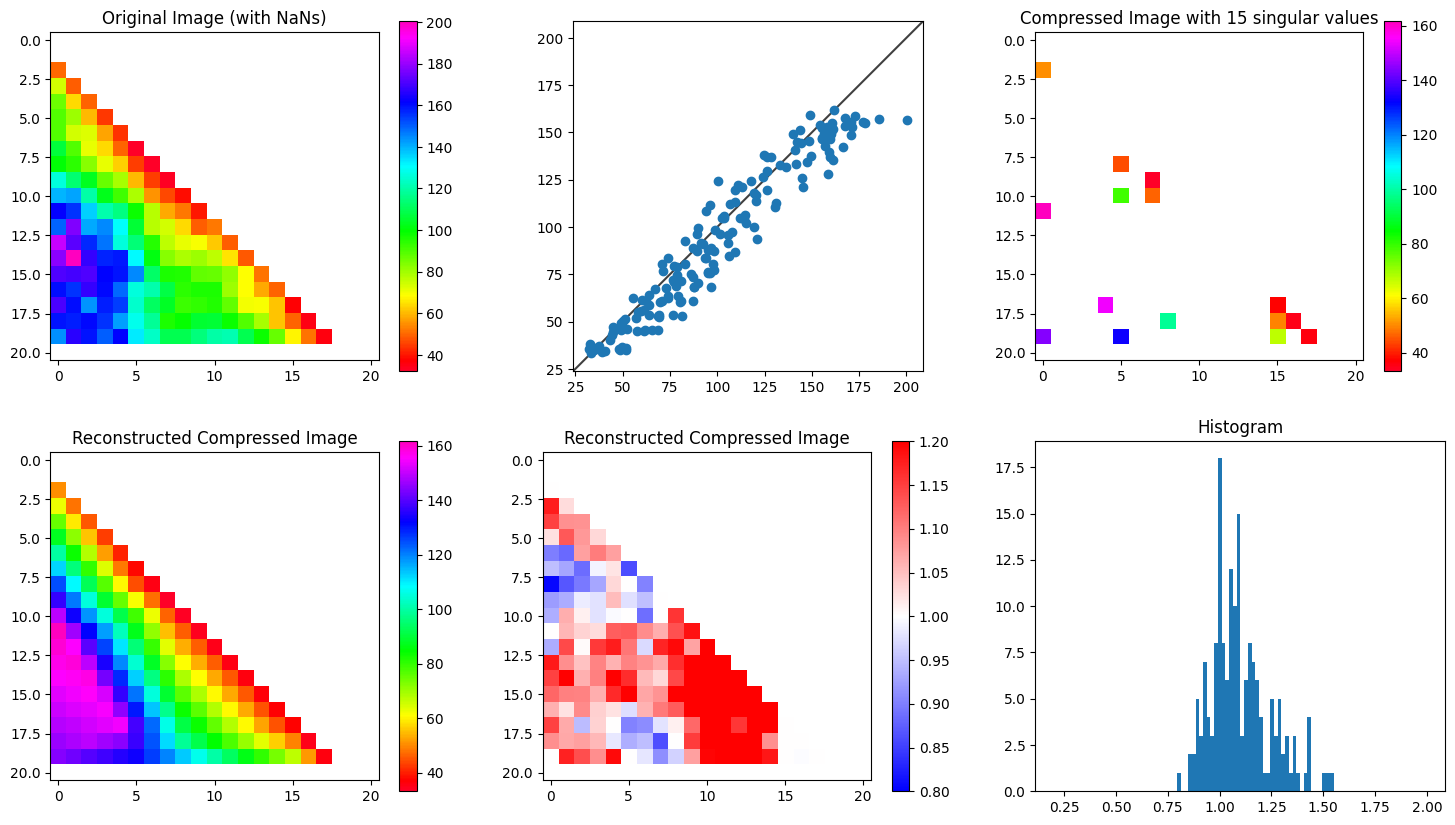

[[ 2 19 11 18 18 19  9 17 19  8 17 10 18 10 19]
 [ 0  0  0 15 16 17  7 15  5  5  4  5  8  7 15]]


In [ ]:
fig , ( (ax1,ax2,ax5) , (ax3,ax4,ax6)) = plt.subplots(2,3, figsize=(18,10))

#Plot 1: Original Image  
ax1.set_title("Original Image (with NaNs)")
im1=ax1.imshow(image, cmap='gist_rainbow')
plt.colorbar(im1)

#Plot 2: Scatter Plot
ax2.scatter(image.ravel(),reconstructed_compressed_image.ravel())

lims = [
np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)

#Plot 3: Reconstructed Image
ax3.set_title("Reconstructed Compressed Image")
reconstructed_compressed_image[nan_mask] = np.nan
im3=ax3.imshow(reconstructed_compressed_image, cmap='gist_rainbow')
plt.colorbar(im3)

#Plot 4: Ratio Image
ax4.set_title("Reconstructed Compressed Image")
im4=ax4.imshow(image/reconstructed_compressed_image, cmap='bwr',vmin=0.8,vmax=1.2)
plt.colorbar(im4)

#Plot 5: Compressed Image
del1=np.asarray(significant_indices)
to_plot_image=np.copy(image)
to_plot_image[:]=np.nan
to_plot_image[del1[0,:].T,del1[1,:].T]=predicted_values

ax5.set_title(f"Compressed Image with {num_singular_values} singular values")
compressed_image[nan_mask] = np.nan
im5=ax5.imshow(to_plot_image, cmap='gist_rainbow')
plt.colorbar(im5)

#Plot 6: Histogram
ax6.set_title("Histogram")
ax6.hist(image.ravel()/reconstructed_compressed_image.ravel(),bins=100,range=(0.2,2))

print("Significant pixel indices (2D):", significant_indices)
print("Pixel values at significant indices:", pixel_values)
print(np.count_nonzero(np.isfinite(image.ravel())))
print(np.count_nonzero(np.isfinite(pixel_values)))

np.save("compressed.npy",significant_indices)
np.save("")
plt.show()

testing=np.load("compressed.npy")
print(testing)